In [41]:
import re
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from IPython.display import display
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [42]:
df = pd.read_csv('jamb.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [43]:
df.shape


(5000, 17)

In [44]:
df = (
    df
    .drop(columns="student_id")     # Remove the student_id column.
    .fillna(0)                      # Fill missing values with zeros.
)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   jamb_score                    5000 non-null   int64  
 1   study_hours_per_week          5000 non-null   int64  
 2   attendance_rate               5000 non-null   int64  
 3   teacher_quality               5000 non-null   int64  
 4   distance_to_school            5000 non-null   float64
 5   school_type                   5000 non-null   object 
 6   school_location               5000 non-null   object 
 7   extra_tutorials               5000 non-null   object 
 8   access_to_learning_materials  5000 non-null   object 
 9   parent_involvement            5000 non-null   object 
 10  it_knowledge                  5000 non-null   object 
 11  age                           5000 non-null   int64  
 12  gender                        5000 non-null   object 
 13  soc

In [46]:
df = df.drop(labels='student_id', axis=1)

KeyError: "['student_id'] not found in axis"

In [47]:
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [48]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [49]:
df.describe().round()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,age,assignments_completed
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,174.0,20.0,84.0,3.0,10.0,18.0,2.0
std,48.0,10.0,9.0,1.0,5.0,2.0,1.0
min,100.0,0.0,50.0,1.0,0.0,15.0,1.0
25%,135.0,13.0,78.0,2.0,7.0,16.0,1.0
50%,170.0,19.0,84.0,2.0,10.0,18.0,1.0
75%,209.0,26.0,91.0,3.0,13.0,20.0,2.0
max,367.0,40.0,100.0,5.0,20.0,22.0,5.0


In [50]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)


df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]

In [51]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

### Question 1

In [52]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [53]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



### Question 2

In [54]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [55]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))


42.13724207871227

### Question 3

In [56]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

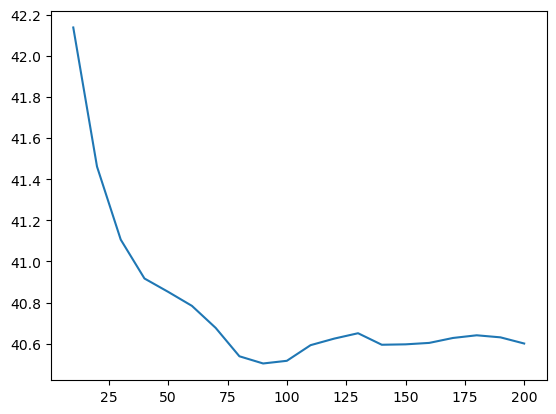

In [57]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

In [58]:
scores = []

rf = RandomForestRegressor(n_estimators=0,
                           random_state=1, n_jobs=-1,
                           warm_start=True)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

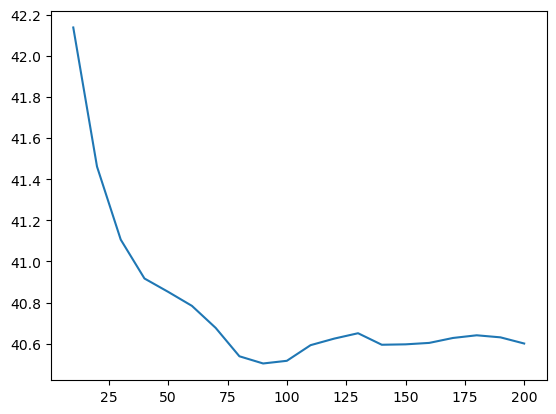

In [59]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

### Question 4

In [60]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

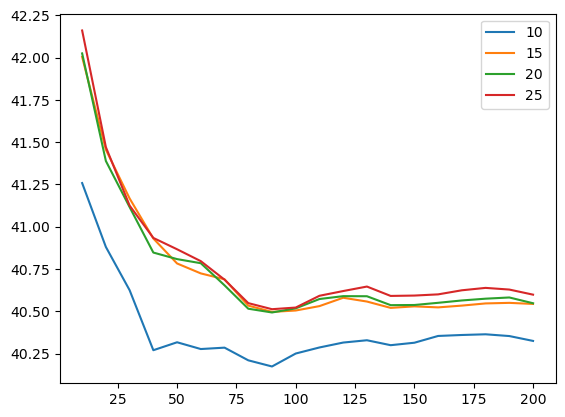

In [61]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

### Question 5

In [62]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [63]:
rf.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [64]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,access_to_learning_materials=No,0.012325
1,access_to_learning_materials=Yes,0.010262
2,age,0.069311
3,assignments_completed,0.031517
4,attendance_rate,0.149729
5,distance_to_school,0.136486
6,extra_tutorials=No,0.013459
7,extra_tutorials=Yes,0.009131
8,gender=Female,0.009289
9,gender=Male,0.010383


In [65]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


### Question 6

In [67]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 270.5 kB/s eta 0:07:40
   ---------------------------------------- 0.5/124.9 MB 270.5 kB/s eta 0:07:40
   ---------------------------------------- 0.5/124.9 MB 270.5 kB/s eta 0:07:40
   ---------------------------------------- 0.5/124.9 MB 270.5 kB/s eta 0:07:40
   ---------------------------------------- 0.5/124.9 MB 270.5 kB/s eta 0:07:40
   -----------------------------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
import xgboost as xgb

In [70]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [72]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [73]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [74]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [75]:
scores['eta=0.3'] = parse_xgb_output(output)

In [76]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [77]:
scores['eta=0.1'] = parse_xgb_output(output)

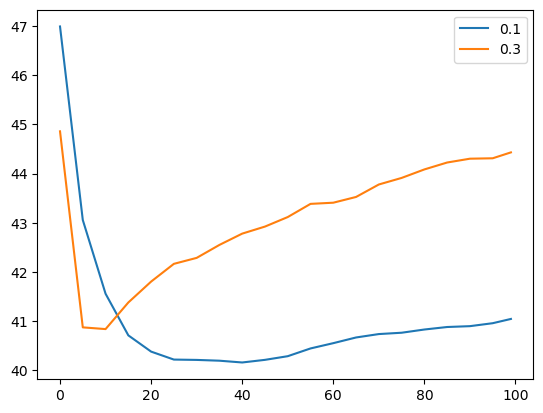

In [78]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.legend()
plt.show()